# ============================================================================
# 1. IMPORTACIÓN DE BIBLIOTECAS
# ============================================================================

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Preprocesamiento y métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score, mean_absolute_percentage_error)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 70)
print(" PREDICCIÓN DE DEMANDA DE PRODUCTOS - ANÁLISIS ML ".center(70))
print("=" * 70)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("=" * 70)

           PREDICCIÓN DE DEMANDA DE PRODUCTOS - ANÁLISIS ML           
TensorFlow version: 2.19.0
GPU disponible: False


# ============================================================================
# 2. CARGA Y EXPLORACIÓN DEL DATASET
# ============================================================================

# CARGAR TU ARCHIVO AQUÍ
# df = pd.read_csv('tu_archivo.csv')
# O si está en Excel:
# df = pd.read_excel('tu_archivo.xlsx')

# Para este ejemplo, crearé un dataset de prueba con tu estructura
# REEMPLAZA esto con: df = pd.read_csv('tu_archivo.csv')

# Simulación de datos (ELIMINAR cuando uses tu archivo real)


In [4]:
np.random.seed(42)
dates = pd.date_range('2016-01-01', periods=10000, freq='D')
df = pd.read_csv('Retail_Dataset2.csv')

print("\n INFORMACIÓN DEL DATASET")
print("=" * 70)
print(f"Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"\nPrimeras 5 filas:")
print(df.head())
print(f"\nTipos de datos:")
print(df.dtypes)
print(f"\nEstadísticas descriptivas:")
print(df.describe())

# Información de valores faltantes
print(f"\n🔍 VALORES FALTANTES:")
print(df.isnull().sum())
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
print(f"\nPorcentaje de valores faltantes:")
print(missing_pct[missing_pct > 0])


 INFORMACIÓN DEL DATASET
Dimensiones: 169211 filas × 11 columnas

Primeras 5 filas:
   Product_id  Product_Code Warehouse Product_Category        Date  \
0      786725  Product_0033    Whse_S     Category_005  01/03/2016   
1      786743  Product_1825    Whse_S     Category_006  01/03/2016   
2      786967  Product_0551    Whse_S     Category_030  01/03/2016   
3      786856  Product_0556    Whse_S     Category_030  01/03/2016   
4      899538  Product_1844    Whse_A     Category_018  01/03/2016   

   Order_Demand  Open  Promo StateHoliday  SchoolHoliday  Petrol_price  
0         16000     1      0            0              0            91  
1         50000     1      0            0              0            85  
2          3000     1      0            0              0            85  
3          1000     1      0            0              0            93  
4             7     1      0            0              0            95  

Tipos de datos:
Product_id           int64
Product_Code

# ============================================================================
# 3. ANÁLISIS EXPLORATORIO ESPECÍFICO
# ============================================================================

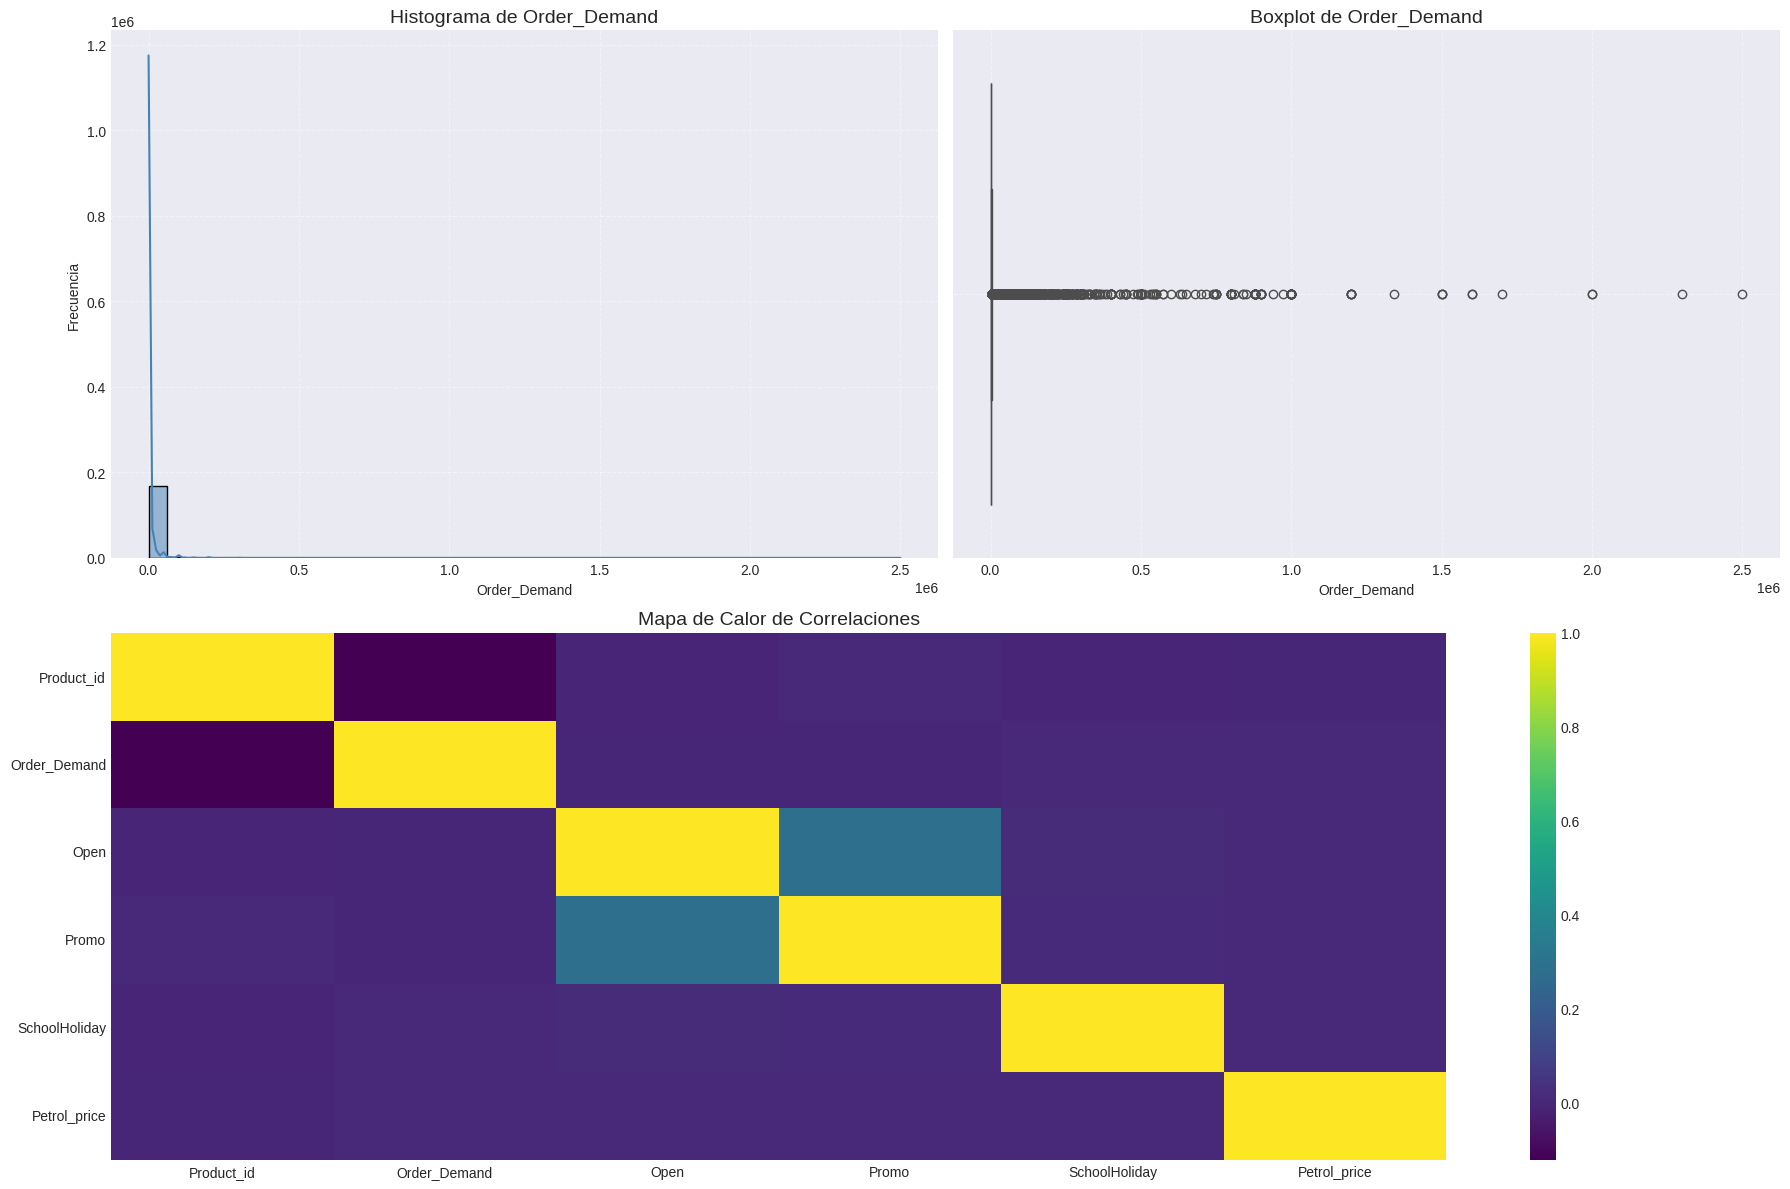

Imagen 'EDA_compuesto.png' generada correctamente.


In [17]:
# Asegurar tipo numérico
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')

# Seleccionar numéricos para el heatmap
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

# ============================
# FIGURA COMPUESTA (3 SUBPLOTS)
# ============================

plt.figure(figsize=(18, 12))

# --- Subplot 1: Histograma ---
plt.subplot(2, 2, 1)
sns.histplot(df['Order_Demand'].dropna(), bins=40, kde=True, color='steelblue')
plt.title("Histograma de Order_Demand", fontsize=14)
plt.xlabel("Order_Demand")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.4)

# --- Subplot 2: Boxplot ---
plt.subplot(2, 2, 2)
sns.boxplot(x=df['Order_Demand'], color='orange')
plt.title("Boxplot de Order_Demand", fontsize=14)
plt.xlabel("Order_Demand")
plt.grid(True, linestyle='--', alpha=0.4)

# --- Subplot 3: Heatmap ---
plt.subplot(2, 2, (3, 4))  # ocupa toda la fila inferior
sns.heatmap(corr, annot=False, cmap='viridis')
plt.title("Mapa de Calor de Correlaciones", fontsize=14)

plt.tight_layout()

# Guardar imagen final
plt.savefig("EDA_compuesto.png", dpi=300, bbox_inches='tight')
plt.show()

print("Imagen 'EDA_compuesto.png' generada correctamente.")


            ANÁLISIS DE LA VARIABLE OBJETIVO: Order_Demand            

Estadísticas de Order_Demand:
count    1.692110e+05
mean     5.248118e+03
std      3.116296e+04
min      0.000000e+00
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      2.500000e+06
Name: Order_Demand, dtype: float64
Mediana: 300.0
Asimetría (Skewness): 28.09
Curtosis: 1242.60


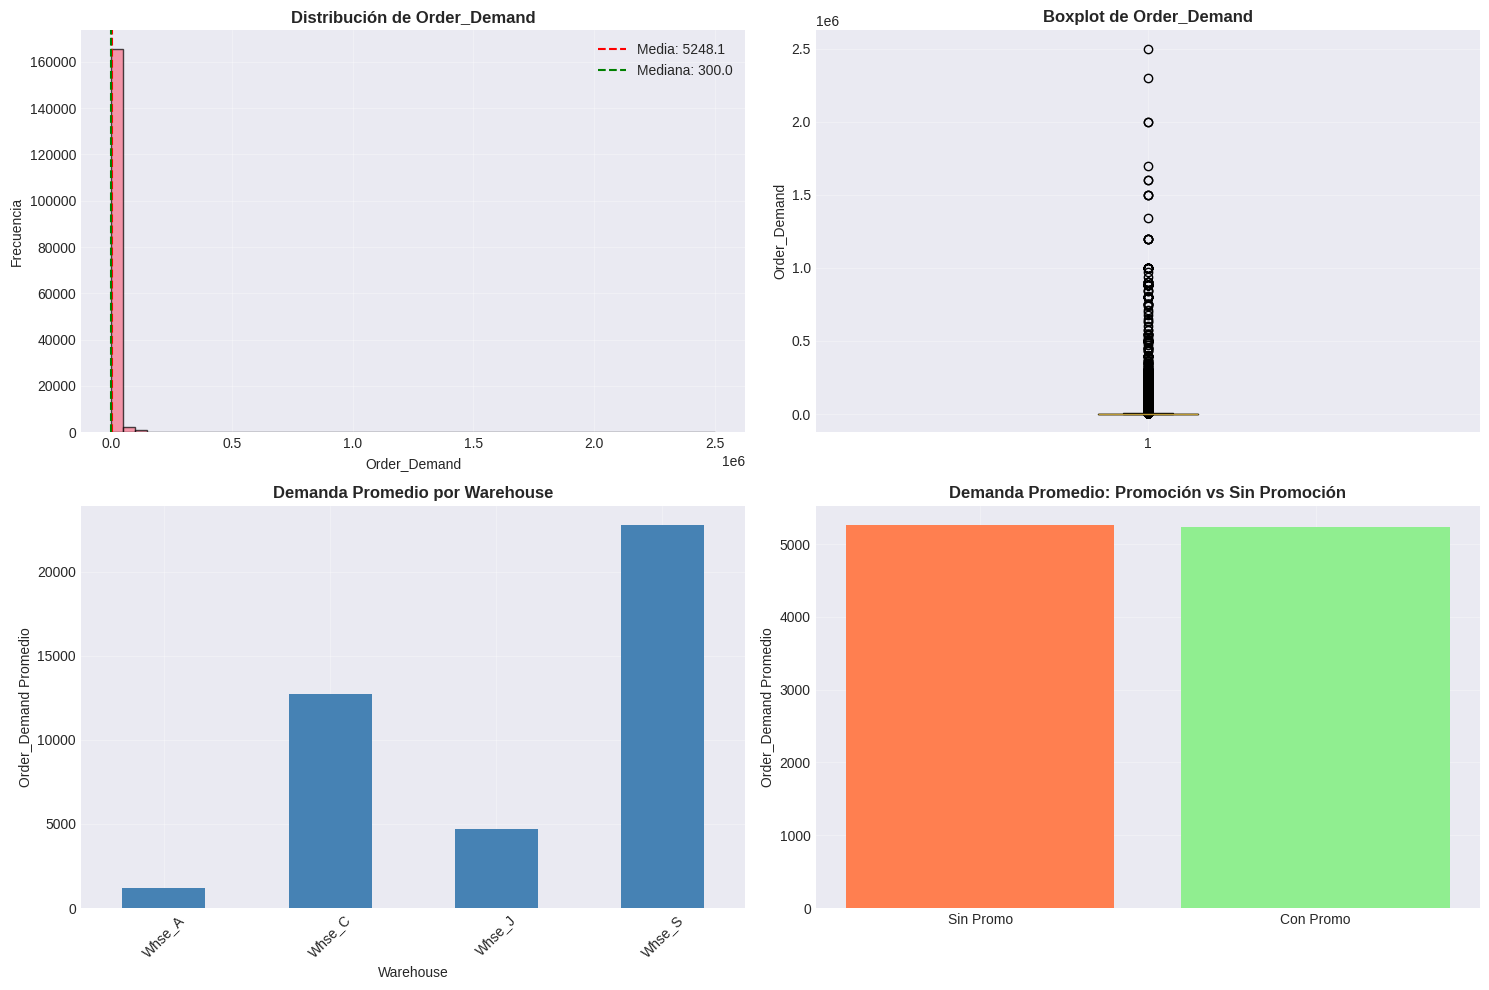


✓ Gráficos de exploración guardados como 'exploracion_order_demand.png'


In [5]:
print("\n" + "=" * 70)
print(" ANÁLISIS DE LA VARIABLE OBJETIVO: Order_Demand ".center(70))
print("=" * 70)

# Estadísticas de Order_Demand
print(f"\nEstadísticas de Order_Demand:")
print(df['Order_Demand'].describe())
print(f"Mediana: {df['Order_Demand'].median()}")
print(f"Asimetría (Skewness): {df['Order_Demand'].skew():.2f}")
print(f"Curtosis: {df['Order_Demand'].kurtosis():.2f}")

# Visualización de Order_Demand
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma
axes[0, 0].hist(df['Order_Demand'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['Order_Demand'].mean(), color='red', linestyle='--',
                    label=f'Media: {df["Order_Demand"].mean():.1f}')
axes[0, 0].axvline(df['Order_Demand'].median(), color='green', linestyle='--',
                    label=f'Mediana: {df["Order_Demand"].median():.1f}')
axes[0, 0].set_title('Distribución de Order_Demand', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Order_Demand')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Boxplot
axes[0, 1].boxplot(df['Order_Demand'], vert=True)
axes[0, 1].set_title('Boxplot de Order_Demand', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Order_Demand')
axes[0, 1].grid(alpha=0.3)

# Demanda por Warehouse
df.groupby('Warehouse')['Order_Demand'].mean().plot(kind='bar', ax=axes[1, 0],
                                                     color='steelblue')
axes[1, 0].set_title('Demanda Promedio por Warehouse', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Warehouse')
axes[1, 0].set_ylabel('Order_Demand Promedio')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(alpha=0.3)

# Demanda con/sin Promoción
promo_demand = df.groupby('Promo')['Order_Demand'].mean()
axes[1, 1].bar(['Sin Promo', 'Con Promo'], promo_demand, color=['coral', 'lightgreen'])
axes[1, 1].set_title('Demanda Promedio: Promoción vs Sin Promoción',
                     fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Order_Demand Promedio')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('exploracion_order_demand.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráficos de exploración guardados como 'exploracion_order_demand.png'")


# ============================================================================
# 4. INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING)
# ============================================================================

In [6]:
print("\n" + "=" * 70)
print(" INGENIERÍA DE CARACTERÍSTICAS ".center(70))
print("=" * 70)

# Crear copia para no modificar original
df_processed = df.copy()

# Convertir Date a datetime si no lo es
df_processed['Date'] = pd.to_datetime(df_processed['Date'])

# Extraer características temporales
df_processed['Year'] = df_processed['Date'].dt.year
df_processed['Month'] = df_processed['Date'].dt.month
df_processed['Day'] = df_processed['Date'].dt.day
df_processed['DayOfWeek'] = df_processed['Date'].dt.dayofweek
df_processed['WeekOfYear'] = df_processed['Date'].dt.isocalendar().week
df_processed['Quarter'] = df_processed['Date'].dt.quarter
df_processed['IsWeekend'] = (df_processed['DayOfWeek'] >= 5).astype(int)

print("✓ Características temporales extraídas:")
print("  - Year, Month, Day, DayOfWeek, WeekOfYear, Quarter, IsWeekend")

# Codificar variables categóricas
categorical_cols = ['Warehouse', 'Product_Category', 'StateHoliday'] # Added StateHoliday

# Label Encoding para columnas categóricas
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
    le_dict[col] = le
    print(f"✓ {col} codificado: {len(le.classes_)} categorías únicas")

# Eliminar columnas no necesarias
cols_to_drop = ['Product_id', 'Product_Code', 'Date', 'Warehouse', 'Product_Category', 'StateHoliday'] # Added StateHoliday to drop list
df_processed = df_processed.drop(columns=cols_to_drop)

print(f"\n✓ Columnas eliminadas: {cols_to_drop}")
print(f"\n📋 Características finales ({df_processed.shape[1]} columnas):")
print(df_processed.columns.tolist())



                    INGENIERÍA DE CARACTERÍSTICAS                     
✓ Características temporales extraídas:
  - Year, Month, Day, DayOfWeek, WeekOfYear, Quarter, IsWeekend
✓ Warehouse codificado: 4 categorías únicas
✓ Product_Category codificado: 30 categorías únicas
✓ StateHoliday codificado: 3 categorías únicas

✓ Columnas eliminadas: ['Product_id', 'Product_Code', 'Date', 'Warehouse', 'Product_Category', 'StateHoliday']

📋 Características finales (15 columnas):
['Order_Demand', 'Open', 'Promo', 'SchoolHoliday', 'Petrol_price', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'IsWeekend', 'Warehouse_encoded', 'Product_Category_encoded', 'StateHoliday_encoded']


# ============================================================================
# 5. PREPARACIÓN DE DATOS
# ============================================================================

In [7]:
print("\n" + "=" * 70)
print(" PREPARACIÓN DE DATOS PARA ENTRENAMIENTO ".center(70))
print("=" * 70)

# Separar features y target
X = df_processed.drop('Order_Demand', axis=1)
y = df_processed['Order_Demand']

print(f"\nDimensiones:")
print(f"  X (features): {X.shape}")
print(f"  y (target): {y.shape}")


               PREPARACIÓN DE DATOS PARA ENTRENAMIENTO                

Dimensiones:
  X (features): (169211, 14)
  y (target): (169211,)


# ============================================================================
# 6. PARTICIÓN DE DATOS (Train/Val/Test) - 60/20/20
# ============================================================================

In [9]:
print("\n" + "=" * 70)
print(" PARTICIÓN DE DATOS ".center(70))
print("=" * 70)

# Primera división: Train+Val (80%) vs Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Segunda división: Train (75% de 80% = 60%) vs Val (25% de 80% = 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True
)

print(f"\n📊 Distribución de datos:")
print(f"  Train: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Val:   {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

# Estadísticas de Order_Demand en cada conjunto
print(f"\n📈 Estadísticas de Order_Demand por conjunto:")
print(f"  Train - Media: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  Val   - Media: {y_val.mean():.2f}, Std: {y_val.std():.2f}")
print(f"  Test  - Media: {y_test.mean():.2f}, Std: {y_test.std():.2f}")


                          PARTICIÓN DE DATOS                          

📊 Distribución de datos:
  Train: 101,526 muestras (60.0%)
  Val:   33,842 muestras (20.0%)
  Test:  33,843 muestras (20.0%)

📈 Estadísticas de Order_Demand por conjunto:
  Train - Media: 5265.39, Std: 31422.80
  Val   - Media: 5148.75, Std: 32321.52
  Test  - Media: 5295.66, Std: 29134.85


# ============================================================================
# 7. NORMALIZACIÓN
# ============================================================================

In [10]:
print("\n" + "=" * 70)
print(" NORMALIZACIÓN DE DATOS ".center(70))
print("=" * 70)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# También normalizar el target para mejor convergencia
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print("✓ Features normalizadas con StandardScaler")
print("✓ Target normalizado con StandardScaler")
print(f"\nEjemplo de normalización:")
print(f"  Original - Min: {X_train.min().min():.2f}, Max: {X_train.max().max():.2f}")
print(f"  Escalado - Min: {X_train_scaled.min():.2f}, Max: {X_train_scaled.max():.2f}")


                        NORMALIZACIÓN DE DATOS                        
✓ Features normalizadas con StandardScaler
✓ Target normalizado con StandardScaler

Ejemplo de normalización:
  Original - Min: 0.00, Max: 2016.00
  Escalado - Min: -2.31, Max: 17.62


# ============================================================================
# 8. DEFINICIÓN DE ARQUITECTURAS
# ============================================================================

In [11]:
def create_model(input_dim, architecture='simple'):
    """
    Crea diferentes arquitecturas de redes neuronales para regresión.

    Arquitecturas disponibles:
    - simple: 2 capas ocultas (64, 32)
    - intermedia: 3 capas con BatchNorm (128, 64, 32)
    - compleja: 4 capas profundas (256, 128, 64, 32)
    """
    model = Sequential(name=f'modelo_{architecture}')

    if architecture == 'simple':
        model.add(Dense(64, activation='relu', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))

    elif architecture == 'intermedia':
        model.add(Dense(128, activation='relu', input_dim=input_dim))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))

    elif architecture == 'compleja':
        model.add(Dense(256, activation='relu', input_dim=input_dim))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))

    # Capa de salida para regresión (sin activación)
    model.add(Dense(1, activation='linear'))

    # Compilación
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',  # Mean Squared Error para regresión
        metrics=['mae', 'mse']  # MAE y MSE como métricas adicionales
    )

    return model

# ============================================================================
# 9. ENTRENAMIENTO DE MODELOS CON DIFERENTES ARQUITECTURAS
# ============================================================================

In [ ]:
print("\n" + "=" * 70)
print(" ENTRENAMIENTO DE MODELOS ".center(70))
print("=" * 70)

# Hiperparámetros
EPOCHS = 100
BATCH_SIZE = 64
input_dim = X_train_scaled.shape[1]

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Diccionario para almacenar resultados
resultados = []
arquitecturas = ['simple', 'intermedia', 'compleja']

for arq in arquitecturas:
    print(f"\n{'='*70}")
    print(f" ENTRENANDO: Arquitectura {arq.upper()} ".center(70))
    print(f"{'='*70}")

    # Crear modelo
    model = create_model(input_dim, architecture=arq)

    print(f"\n📐 Arquitectura del modelo:")
    model.summary()

    # Entrenar
    print(f"\n🚀 Iniciando entrenamiento...")
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop, reduce_lr],
        verbose=0  # Cambiar a 1 para ver progreso detallado
    )

    # Predicciones en escala normalizada
    y_pred_scaled = model.predict(X_val_scaled, verbose=0).flatten()

    # Desnormalizar predicciones
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Calcular métricas en escala original
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred) * 100

    # Guardar resultados
    resultados.append({
        'Arquitectura': arq.capitalize(),
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'Épocas': len(history.history['loss']),
        'History': history,
        'Model': model
    })

    print(f"\n✅ RESULTADOS EN CONJUNTO DE VALIDACIÓN:")
    print(f"  MSE:       {mse:,.2f}")
    print(f"  RMSE:      {rmse:,.2f}")
    print(f"  MAE:       {mae:,.2f}")
    print(f"  R²:        {r2:.4f}")
    print(f"  MAPE:      {mape:.2f}%")
    print(f"  Épocas:    {len(history.history['loss'])}")



                       ENTRENAMIENTO DE MODELOS                       

                   ENTRENANDO: Arquitectura SIMPLE                    

📐 Arquitectura del modelo:


Model: "modelo_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Iniciando entrenamiento...

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 89: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 99: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 99: early stopping
Restoring model weights from the end of the best epoch: 79.

✅ RESULTADOS EN CONJUNTO DE VALIDACIÓN:
  MSE:       967,465,024.00
  RMSE:      31,104.10
  MAE:       7,093.57
  R²:        0.0739
  MAPE:      28975316539644313600.00%
  Épocas:    99

                 ENTRENANDO: Arquitectura INTERMEDIA                  

📐 Arquitectura del modelo:


Model: "modelo_intermedia"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 12,673 (49.50 KB)

 Non-trainable params: 384 (1.50 KB)


🚀 Iniciando entrenamiento...

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 90: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 70.

✅ RESULTADOS EN CONJUNTO DE VALIDACIÓN:
  MSE:       955,219,456.00
  RMSE:      30,906.62
  MAE:       6,716.27
  R²:        0.0856
  MAPE:      19555879451885568000.00%
  Épocas:    90

                  ENTRENANDO: Arquitectura COMPLEJA                   

📐 Arquitectura del modelo:


Model: "modelo_compleja"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,897 (191.00 KB)

 Trainable params: 48,001 (187.50 KB)

 Non-trainable params: 896 (3.50 KB)


🚀 Iniciando entrenamiento...

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 54: early stopping
Restoring model weights from the end of the best epoch: 34.

✅ RESULTADOS EN CONJUNTO DE VALIDACIÓN:
  MSE:       969,684,928.00
  RMSE:      31,139.76
  MAE:       6,916.85
  R²:        0.0718
  MAPE:      24598097183952076800.00%
  Épocas:    54


# ============================================================================
# 10. COMPARACIÓN DE MODELOS
# ============================================================================



                     COMPARACIÓN DE ARQUITECTURAS                     

Arquitectura         MSE         RMSE         MAE       R²     MAPE (%)  Épocas
      Simple 967465024.0 31104.099794 7093.574219 0.073886 2.897532e+19      99
  Intermedia 955219456.0 30906.624791 6716.272949 0.085608 1.955588e+19      90
    Compleja 969684928.0 31139.764418 6916.853027 0.071761 2.459810e+19      54

✓ Resultados guardados en 'comparacion_arquitecturas.csv'


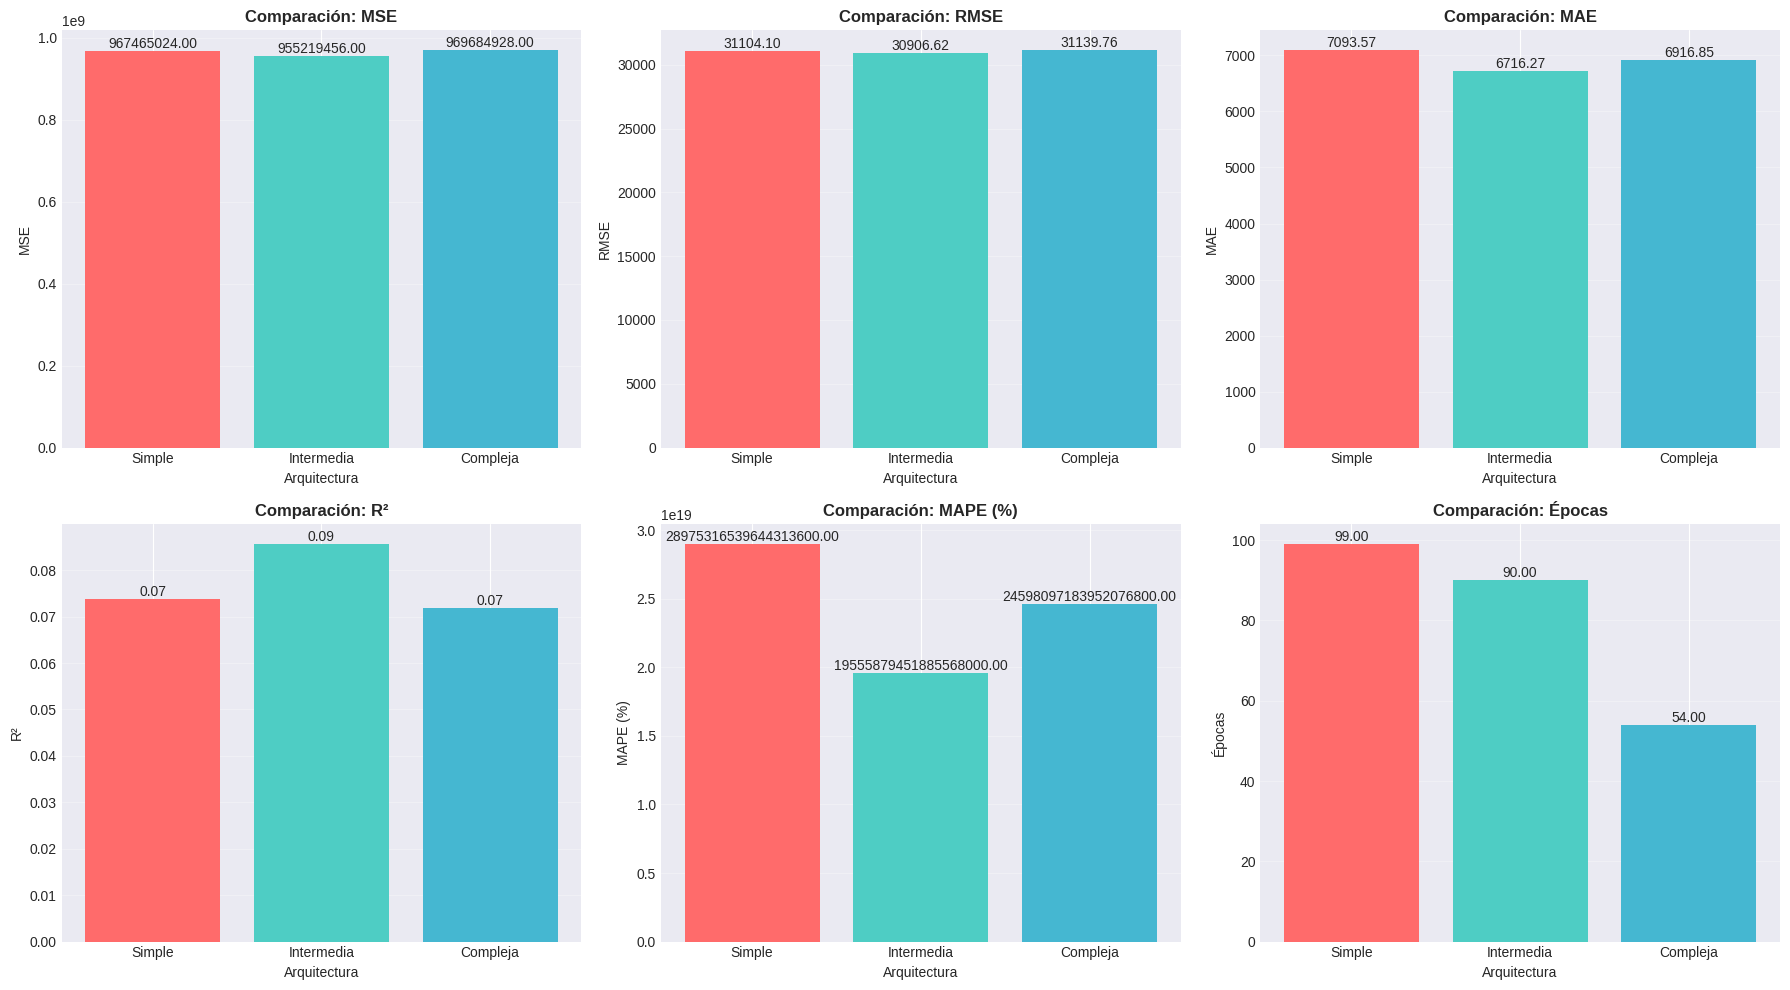

✓ Gráfico guardado como 'comparacion_arquitecturas.png'


In [ ]:
print("\n" + "=" * 70)
print(" COMPARACIÓN DE ARQUITECTURAS ".center(70))
print("=" * 70)

# Crear DataFrame con resultados
df_resultados = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ['History', 'Model']}
    for r in resultados
])

print("\n" + df_resultados.to_string(index=False))

# Guardar resultados
df_resultados.to_csv('comparacion_arquitecturas.csv', index=False)
print("\n✓ Resultados guardados en 'comparacion_arquitecturas.csv'")

# Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['MSE', 'RMSE', 'MAE', 'R²', 'MAPE (%)', 'Épocas']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    bars = ax.bar(df_resultados['Arquitectura'], df_resultados[metric], color=colors)
    ax.set_title(f'Comparación: {metric}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Arquitectura')
    ax.set_ylabel(metric)
    ax.grid(axis='y', alpha=0.3)

    # Añadir valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('comparacion_arquitecturas.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado como 'comparacion_arquitecturas.png'")

# ============================================================================
# 11. ANÁLISIS DEL MEJOR MODELO
# ============================================================================


                       MEJOR MODELO: INTERMEDIA                       

🏆 Métricas del mejor modelo:
  MSE:       955,219,456.00
  RMSE:      30,906.62
  MAE:       6,716.27
  R²:        0.0856
  MAPE:      19555879451885568000.00%


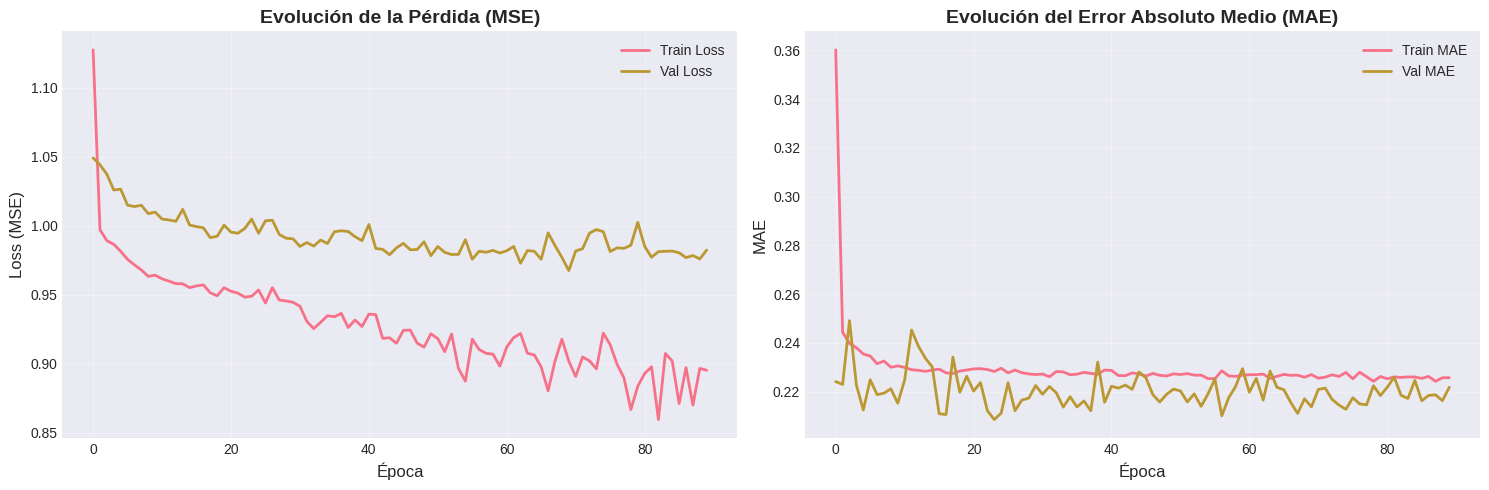


✓ Curvas de aprendizaje guardadas como 'curvas_aprendizaje_mejor_modelo.png'


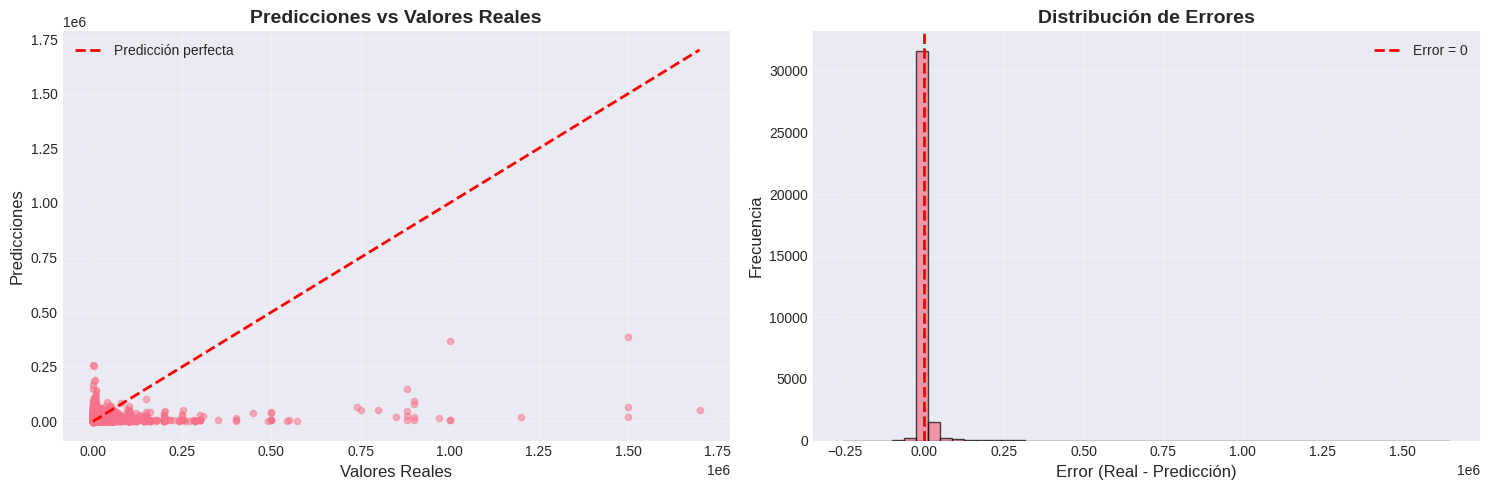

✓ Gráfico de predicciones guardado como 'predicciones_vs_reales.png'


In [ ]:
# Seleccionar mejor modelo (menor MAE)
mejor_idx = df_resultados['MAE'].idxmin()
mejor_modelo_info = resultados[mejor_idx]

print("\n" + "=" * 70)
print(f" MEJOR MODELO: {mejor_modelo_info['Arquitectura'].upper()} ".center(70))
print("=" * 70)

mejor_modelo = mejor_modelo_info['Model']
mejor_history = mejor_modelo_info['History']

print(f"\n🏆 Métricas del mejor modelo:")
print(f"  MSE:       {mejor_modelo_info['MSE']:,.2f}")
print(f"  RMSE:      {mejor_modelo_info['RMSE']:,.2f}")
print(f"  MAE:       {mejor_modelo_info['MAE']:,.2f}")
print(f"  R²:        {mejor_modelo_info['R²']:.4f}")
print(f"  MAPE:      {mejor_modelo_info['MAPE (%)']:.2f}%")

# Curvas de aprendizaje
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(mejor_history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(mejor_history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Evolución de la Pérdida (MSE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(mejor_history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(mejor_history.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_title('Evolución del Error Absoluto Medio (MAE)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('curvas_aprendizaje_mejor_modelo.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Curvas de aprendizaje guardadas como 'curvas_aprendizaje_mejor_modelo.png'")

# Predicciones vs Valores Reales
y_pred_best_scaled = mejor_modelo.predict(X_val_scaled, verbose=0).flatten()
y_pred_best = scaler_y.inverse_transform(y_pred_best_scaled.reshape(-1, 1)).flatten()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: Predicciones vs Reales
axes[0].scatter(y_val, y_pred_best, alpha=0.5, s=20)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
             'r--', lw=2, label='Predicción perfecta')
axes[0].set_xlabel('Valores Reales', fontsize=12)
axes[0].set_ylabel('Predicciones', fontsize=12)
axes[0].set_title('Predicciones vs Valores Reales', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribución de errores
errores = y_val - y_pred_best
axes[1].hist(errores, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes[1].set_xlabel('Error (Real - Predicción)', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Distribución de Errores', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('predicciones_vs_reales.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico de predicciones guardado como 'predicciones_vs_reales.png'")

# ============================================================================
# 12. EVALUACIÓN FINAL EN CONJUNTO DE TEST
# ============================================================================

In [ ]:
print("\n" + "=" * 70)
print(" EVALUACIÓN FINAL EN CONJUNTO DE TEST ".center(70))
print("=" * 70)

y_test_pred_scaled = mejor_modelo.predict(X_test_scaled, verbose=0).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Métricas en test
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print(f"\n🎯 RESULTADOS EN CONJUNTO DE TEST:")
print(f"  MSE:       {test_mse:,.2f}")
print(f"  RMSE:      {test_rmse:,.2f}")
print(f"  MAE:       {test_mae:,.2f}")
print(f"  R²:        {test_r2:.4f}")
print(f"  MAPE:      {test_mape:.2f}%")


                 EVALUACIÓN FINAL EN CONJUNTO DE TEST                 

🎯 RESULTADOS EN CONJUNTO DE TEST:
  MSE:       833,489,792.00
  RMSE:      28,870.22
  MAE:       6,845.42
  R²:        0.0181
  MAPE:      19973590791225344000.00%


# ============================================================================
# 13. GUARDAR MODELO Y ARTEFACTOS
# ============================================================================

In [ ]:
print("\n" + "=" * 70)
print(" GUARDANDO MODELO Y ARTEFACTOS ".center(70))
print("=" * 70)

# Guardar modelo
mejor_modelo.save('mejor_modelo_demanda.h5')
print("✓ Modelo guardado como 'mejor_modelo_demanda.h5'")

# Guardar scalers
import pickle
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
print("✓ Scalers guardados (scaler_X.pkl, scaler_y.pkl)")

# Resumen final para el informe
resumen_final = {
    'Mejor_Arquitectura': mejor_modelo_info['Arquitectura'],
    'Val_MAE': mejor_modelo_info['MAE'],
    'Val_R2': mejor_modelo_info['R²'],
    'Test_MAE': test_mae,
    'Test_R2': test_r2,
    'Total_Parametros': mejor_modelo.count_params(),
    'Epocas_Entrenadas': mejor_modelo_info['Épocas']
}

pd.DataFrame([resumen_final]).to_csv('resumen_final.csv', index=False)
print("✓ Resumen final guardado en 'resumen_final.csv'")

print("\n" + "=" * 70)
print(" ✅ PROCESO COMPLETADO EXITOSAMENTE ".center(70))
print("=" * 70)
print("\n📁 Archivos generados:")
print("  1. mejor_modelo_demanda.h5")
print("  2. comparacion_arquitecturas.csv")
print("  3. resumen_final.csv")
print("  4. scaler_X.pkl, scaler_y.pkl")
print("  5. exploracion_order_demand.png")
print("  6. comparacion_arquitecturas.png")
print("  7. curvas_aprendizaje_mejor_modelo.png")
print("  8. predicciones_vs_reales.png")


                    GUARDANDO MODELO Y ARTEFACTOS                     
✓ Modelo guardado como 'mejor_modelo_demanda.h5'
✓ Scalers guardados (scaler_X.pkl, scaler_y.pkl)
✓ Resumen final guardado en 'resumen_final.csv'

                  ✅ PROCESO COMPLETADO EXITOSAMENTE                   

📁 Archivos generados:
  1. mejor_modelo_demanda.h5
  2. comparacion_arquitecturas.csv
  3. resumen_final.csv
  4. scaler_X.pkl, scaler_y.pkl
  5. exploracion_order_demand.png
  6. comparacion_arquitecturas.png
  7. curvas_aprendizaje_mejor_modelo.png
  8. predicciones_vs_reales.png


In [13]:


# 1) Buscar automáticamente el DataFrame que tenga la columna 'Order_Demand'
df_base = pd.read_csv('Retail_Dataset2.csv')

for name, obj in globals().items():
    if isinstance(obj, pd.DataFrame) and 'Order_Demand' in obj.columns:
        df_base = obj
        print(f"✅ Usando el DataFrame: {name}")
        break

if df_base is None:
    raise ValueError("⚠ No se encontró ningún DataFrame con la columna 'Order_Demand'.")

# 2) Asegurar que la columna sea numérica
df_base['Order_Demand'] = pd.to_numeric(df_base['Order_Demand'], errors='coerce')

# 3) Eliminar NaN solo para el análisis IQR
serie = df_base['Order_Demand'].dropna()

# 4) Cálculo de IQR
Q1 = serie.quantile(0.25)
Q3 = serie.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 5) Outliers
outliers_mask = (serie < lower_bound) | (serie > upper_bound)
n_outliers = outliers_mask.sum()
pct_outliers = (n_outliers / len(serie)) * 100 if len(serie) > 0 else 0

# 6) Mostrar resultados
print("\n=== RESULTADOS IQR ===")
print(f"Q1 (25%): {Q1:.2f}")
print(f"Q3 (75%): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Límite inferior: {lower_bound:.2f}")
print(f"Límite superior: {upper_bound:.2f}")
print(f"Outliers detectados: {n_outliers}")
print(f"Porcentaje de outliers: {pct_outliers:.2f}%")

# 7) Crear tabla IQR para el informe
tabla_iqr = pd.DataFrame({
    "Ítem": [
        "Q1 (Percentil 25)",
        "Q3 (Percentil 75)",
        "IQR (Q3 - Q1)",
        "Límite inferior (Q1 - 1.5×IQR)",
        "Límite superior (Q3 + 1.5×IQR)",
        "Total de outliers detectados",
        "Porcentaje respecto al total"
    ],
    "Valor": [
        Q1,
        Q3,
        IQR,
        lower_bound,
        upper_bound,
        int(n_outliers),
        f"{pct_outliers:.2f}%"
    ]
})

print("\n=== TABLA IQR ===")
display(tabla_iqr)

# 8) Guardar en CSV (por si quieres usar la tabla en Word)
tabla_iqr.to_csv("tabla_IQR.csv", index=False)
print("\n✅ Archivo 'tabla_IQR.csv' generado correctamente.")


✅ Usando el DataFrame: df

=== RESULTADOS IQR ===
Q1 (25%): 20.00
Q3 (75%): 2000.00
IQR: 1980.00
Límite inferior: -2950.00
Límite superior: 4970.00
Outliers detectados: 30958
Porcentaje de outliers: 18.30%

=== TABLA IQR ===


,Ítem,Valor
0,Q1 (Percentil 25),20.0
1,Q3 (Percentil 75),2000.0
2,IQR (Q3 - Q1),1980.0
3,Límite inferior (Q1 - 1.5×IQR),-2950.0
4,Límite superior (Q3 + 1.5×IQR),4970.0
5,Total de outliers detectados,30958
6,Porcentaje respecto al total,18.30%



✅ Archivo 'tabla_IQR.csv' generado correctamente.


from matplotlib import pyplot as plt
import seaborn as sns
tabla_iqr.groupby('Ítem').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
tabla_iqr.groupby('Valor').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

UFuncTypeError: ufunc 'greater' did not contain a loop with signature matching types (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Valor'].value_counts()
    for x_label, grp in tabla_iqr.groupby('Ítem')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Ítem')
_ = plt.ylabel('Valor')

In [19]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ==========================================
# 1) Cargar datos base
# ==========================================
df = pd.read_csv('Retail_Dataset2.csv')

# Asegurar que Order_Demand sea numérico
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')

# Eliminar filas sin demanda
df = df.dropna(subset=['Order_Demand'])

# Usaremos solo columnas numéricas como features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Order_Demand' in numeric_cols:
    numeric_cols.remove('Order_Demand')

X = df[numeric_cols].values
y = df['Order_Demand'].values

print("Columnas usadas como features:", numeric_cols)
print("Tamaño total del dataset:", X.shape)

# ==========================================
# 2) Train / Val split
# ==========================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalado
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

# ==========================================
# 3) MODELOS DE MACHINE LEARNING
# ==========================================
modelos_ml = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        random_state=42
    )
}

resultados_ml = []

for nombre, modelo in modelos_ml.items():
    print(f"\nEntrenando modelo ML: {nombre}")
    modelo.fit(X_train_scaled, y_train)

    y_val_pred = modelo.predict(X_val_scaled)

    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mape = mean_absolute_percentage_error(y_val, y_val_pred) * 100

    resultados_ml.append({
        'Tipo': 'ML',
        'Modelo': nombre,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    })

# ==========================================
# 4) MODELOS DE DEEP LEARNING (MLP)
# ==========================================

def build_mlp_simple(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # regresión
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_mlp_intermedio(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_mlp_complejo(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

arquitecturas_dl = {
    'MLP Simple': build_mlp_simple,
    'MLP Intermedio': build_mlp_intermedio,
    'MLP Complejo': build_mlp_complejo
}

resultados_dl = []

for nombre, builder in arquitecturas_dl.items():
    print(f"\nEntrenando modelo DL: {nombre}")
    model = builder(X_train_scaled.shape[1])

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    y_val_pred = model.predict(X_val_scaled).flatten()

    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mape = mean_absolute_percentage_error(y_val, y_val_pred) * 100

    resultados_dl.append({
        'Tipo': 'DL',
        'Modelo': nombre,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    })

# ==========================================
# 5) TABLA COMPARATIVA ML + DL
# ==========================================
df_ml = pd.DataFrame(resultados_ml)
df_dl = pd.DataFrame(resultados_dl)

df_comparacion = pd.concat([df_ml, df_dl], ignore_index=True)

print("\n=== TABLA COMPARATIVA ML + DL ===")
print(df_comparacion)

# Guardar a CSV para usarlo en el informe
df_comparacion.to_csv("comparacion_ml_dl.csv", index=False)
print("\n✅ Archivo 'comparacion_ml_dl.csv' generado correctamente.")

Columnas usadas como features: ['Product_id', 'Open', 'Promo', 'SchoolHoliday', 'Petrol_price']
Tamaño total del dataset: (169211, 5)

Entrenando modelo ML: Linear Regression

Entrenando modelo ML: Random Forest

Entrenando modelo ML: Gradient Boosting

Entrenando modelo DL: MLP Simple
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Entrenando modelo DL: MLP Intermedio
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Entrenando modelo DL: MLP Complejo
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

=== TABLA COMPARATIVA ML + DL ===
  Tipo             Modelo           MSE          RMSE          MAE        R²  \
0   ML  Linear Regression  8.348666e+08  28894.058773  7337.427991  0.016432   
1   ML      Random Forest  6.254312e+08  25008.622158  4914.468034  0.263171   
2   ML  Gradient Boosting  5.853849e+08  24194.729765  6098.363110  0.310350   
3   DL         MLP Simple  8.345521e+08  28888.615889  7159.747070  0.016802   
4   DL     MLP Intermedio  8.337790e+08  28875.231739  7162.684082  0.01771

In [20]:
# === MODELO INTERMEDIO (el mejor en tus métricas) ===
def build_mlp_intermedio(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_mlp_intermedio(X_train_scaled.shape[1])

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1329974144.0000 - val_loss: 835248064.0000
Epoch 2/100
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 846121088.0000 - val_loss: 834667328.0000
Epoch 3/100
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1025574400.0000 - val_loss: 834502720.0000
Epoch 4/100
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 908641536.0000 - val_loss: 834480448.0000
Epoch 5/100
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1113811328.0000 - val_loss: 834476480.0000
Epoch 6/100
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1091330688.0000 - val_loss: 834444416.0000
Epoch 7/100
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1015249984.0000 - val_loss: 834417600.0000
Epoch 8/100
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1078234752.0000 - val_loss: 834427520.0000
Epoch 9/100
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 806537856.0000 - val_loss: 834406208.0000
Epoch 10/100
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 5s 2

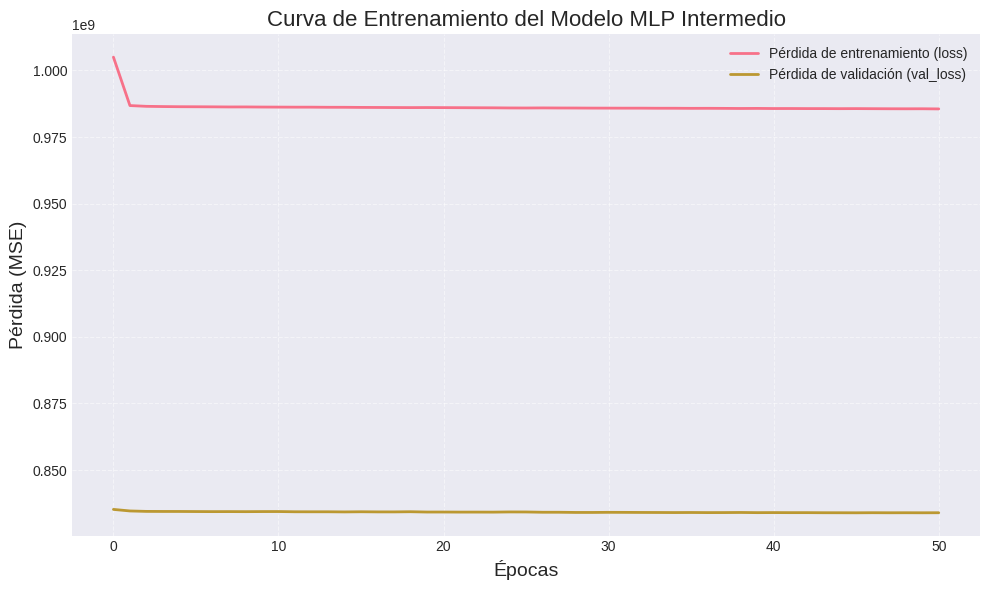

Imagen guardada como 'curva_entrenamiento_mlp.png'


In [21]:
# ============================
# CURVA DE ENTRENAMIENTO
# ============================

plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Pérdida de entrenamiento (loss)', linewidth=2)
plt.plot(history.history['val_loss'], label='Pérdida de validación (val_loss)', linewidth=2)

plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Pérdida (MSE)', fontsize=14)
plt.title('Curva de Entrenamiento del Modelo MLP Intermedio', fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("curva_entrenamiento_mlp.png", dpi=300, bbox_inches='tight')
plt.show()

print("Imagen guardada como 'curva_entrenamiento_mlp.png'")

Columnas usadas como features: ['Product_id', 'Open', 'Promo', 'SchoolHoliday', 'Petrol_price']


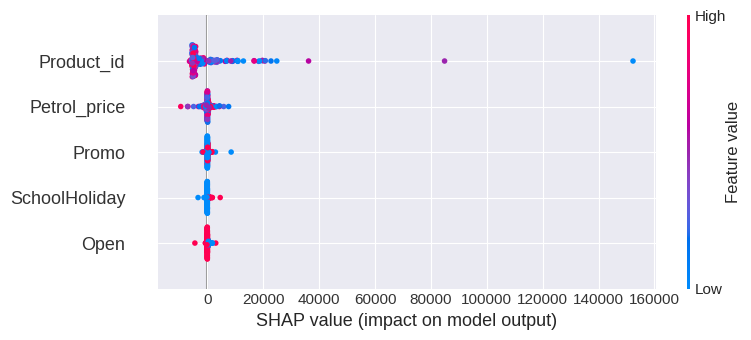

✅ Gráfico SHAP guardado como 'shap_summary_rf.png'


In [22]:
!pip install shap

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# ==========================================
# CARGA Y PREPARACIÓN BÁSICA (tu misma BD)
# ==========================================
df = pd.read_csv('Retail_Dataset2.csv')

# Asegurar que la variable objetivo sea numérica
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')
df = df.dropna(subset=['Order_Demand'])

# Usar solo columnas numéricas como features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('Order_Demand')

X = df[numeric_cols].values
y = df['Order_Demand'].values

print("Columnas usadas como features:", numeric_cols)

# División 60/20/20 → primero 60/40, luego 40 → 20/20
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ==========================================
# ENTRENAR UN MODELO PARA EXPLICAR CON SHAP
# (usamos RandomForest porque SHAP TreeExplainer va perfecto)
# ==========================================
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

# ==========================================
# SHAP PARA EXPLICABILIDAD
# ==========================================

# Creamos una muestra para que sea más rápido
X_sample = X_val_scaled[:200]

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

# Gráfico SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=numeric_cols,
    show=False  # para poder guardar antes de mostrar
)
plt.tight_layout()
plt.savefig("shap_summary_rf.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico SHAP guardado como 'shap_summary_rf.png'")

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Predicciones en TEST
y_test_pred = model.predict(X_test_scaled).flatten()

# Cálculo de métricas
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print("=== MÉTRICAS EN TEST ===")
print(f"MSE:  {mse_test:,.2f}")
print(f"RMSE: {rmse_test:,.2f}")
print(f"MAE:  {mae_test:,.2f}")
print(f"R²:   {r2_test:.4f}")
print(f"MAPE: {mape_test:.2f}%")

# Tabla para el informe
metricas_test = pd.DataFrame({
    "Métrica": ["MSE", "RMSE", "MAE", "R²", "MAPE (%)"],
    "Valor":   [mse_test, rmse_test, mae_test, r2_test, mape_test]
})

print("\n=== TABLA MÉTRICAS TEST ===")
display(metricas_test)

# Guardar por si la quieres abrir/copiar desde CSV
metricas_test.to_csv("metricas_test.csv", index=False)
print("\n✅ Archivo 'metricas_test.csv' generado.")

1058/1058 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
=== MÉTRICAS EN TEST ===
MSE:  793,463,936.00
RMSE: 28,168.49
MAE:  7,211.82
R²:   0.0201
MAPE: 16666247788966707200.00%

=== TABLA MÉTRICAS TEST ===


,Métrica,Valor
0,MSE,7.934639e+08
1,RMSE,2.816849e+04
2,MAE,7.211823e+03
3,R²,2.011991e-02
4,MAPE (%),1.666625e+19



✅ Archivo 'metricas_test.csv' generado.


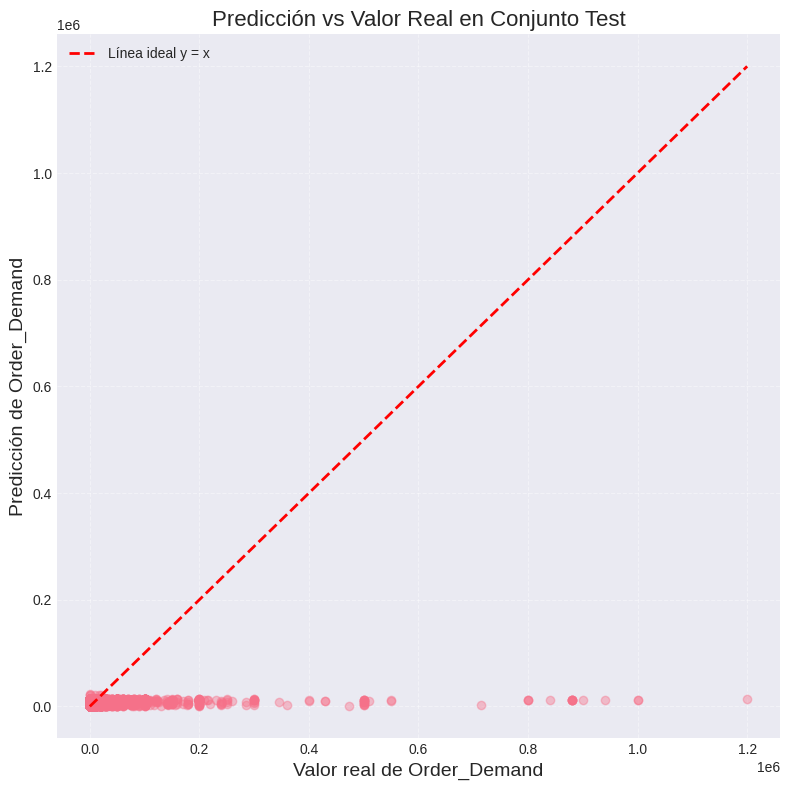

✅ Gráfico guardado como 'pred_vs_real_test.png'


In [24]:

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.4)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Línea ideal y = x')

plt.title("Predicción vs Valor Real en Conjunto Test", fontsize=16)
plt.xlabel("Valor real de Order_Demand", fontsize=14)
plt.ylabel("Predicción de Order_Demand", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("pred_vs_real_test.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado como 'pred_vs_real_test.png'")